In [46]:
import pylidc as pl
import matplotlib.pyplot as plt
import numpy as np
from skimage.measure import find_contours
from pylidc.utils import consensus
from skimage.filters import sobel

In [47]:
def get_malignancy(anns):
    #Get the Malignancy of the lesion
    #
    #   1-‘Highly Unlikely’
    #   2-‘Moderately Unlikely’
    #   3-‘Indeterminate’
    #   4-‘Moderately Suspicious’
    #   5-‘Highly Suspicious’
    #this feature will be used as a label to the dataset
    malignancy=0
    for i in range(len(anns)):
        malignancy+=anns[i].malignancy
    malignancy/=len(anns)
    malignancy=round(malignancy)

    return malignancy

In [48]:
def get_calcification(anns):
    #Get the pattern of calcification if present
    # 
    #   1-‘Popcorn’
    #   2-‘Laminated’
    #   3-‘Solid’
    #   4-‘Non-central’
    #   5-‘Central’
    #   6-‘Absent’
    calcification=0
    for i in range(len(anns)):
        calcification+=anns[i].calcification
    calcification/=len(anns)
    calcification=round(calcification)
    return calcification

In [49]:
def get_lobulation(anns):
    #Get the degree of lobulationof the lesion
    #
    #   1-‘No Lobulation’
    #   2-‘Nearly No Lobulation’
    #   3-‘Medium Lobulation’
    #   4-‘Near Marked Lobulation’
    #   5-‘Marked Lobulation’

    lobulation=0
    for i in range(len(anns)):
        lobulation+=anns[i].lobulation
    lobulation/=len(anns)
    lobulation=round(lobulation)
    return lobulation

In [50]:
def get_spiculation(anns):
    #Get the extent of spiculation present in the lesion
    #
    #   ‘No Spiculation’
    #   ‘Nearly No Spiculation’
    #   ‘Medium Spiculation’
    #   ‘Near Marked Spiculation’
    #   ‘Marked Spiculation’
    spiculation=0
    for i in range(len(anns)):
        spiculation+=anns[i].spiculation
    spiculation/=len(anns)
    spiculation=round(spiculation)
    return spiculation

In [51]:
def get_internal_texture(anns):
    #Get the internal texture of the lesion
    #
    #    1-‘Non-Solid/GGO’
    #    2-‘Non-Solid/Mixed’
    #    3-‘Part Solid/Mixed’
    #    4-‘Solid/Mixed’
    #    5-‘Solid’
    texture=0
    for i in range(len(anns)):
        texture+=anns[i].texture
    texture/=len(anns)
    texture=round(texture)
    return texture

In [52]:
def get_diameter_surface_area_volume(anns):
    #Get the mean value of all anotations for this lesion of the diameter, surface_area, volume
    diameter=0
    surface_area=0
    volume=0
    for i in range(len(anns)):
        diameter+=anns[i].diameter
        surface_area+=anns[i].surface_area
        volume+=anns[i].volume
    diameter/=len(anns)
    surface_area/=len(anns)
    volume/=len(anns)

    return diameter,surface_area,volume

In [53]:
def get_pixeis_in(cmask):
    #Calculating the number of pixeis inside a lesion
    return np.sum(cmask)

In [54]:
def get_circularity(cmask):
    # Calculate circularity
    # the closer to 1 the closer to a perfect circle
    circularity=0
    for i in range(cmask.shape[-1]):
        area_k_slice_pixels=np.sum(cmask[:,:,i])#this way we get the number of pixeis of the k
        # Calculating the perimeter(in pixels) by appling an edge filter to the mask
        edges=sobel(cmask)
        perimeter_piexels=np.sum(edges[:,:,i])#so that we get the perimeter of the slice i of the lesion
        if(perimeter_piexels==0):
            circularity+=0
        else:
            circularity += (4 * np.pi * area_k_slice_pixels) / (perimeter_piexels ** 2)
    circularity/=cmask.shape[-1]

    return circularity

In [55]:
def get_median_hu(nodule_hu_values):
    #Calculate the median HU inside of the lesion
    #vol[ccbox][cmask] represents the HU inside the lesion
    return np.median(nodule_hu_values)

In [56]:
def get_std_hu(nodule_hu_values):
    #Calculate the the standard variation of HU inside the lesion
    return np.std(nodule_hu_values)

In [57]:
def get_var_hu(nodule_hu_values):
    #Calculate the variance of HU inside the lesion
    return np.var(nodule_hu_values)

In [58]:
def get_mean_hu(nodule_hu_values):
    #Calculate the mean of HU inside the lesion
    return np.mean(nodule_hu_values)

Loading dicom files ... This may take a moment.

Nodule 1:
shape cmaks(76, 69, 8)
Number of annotations: 1
Malignancy of the nodule: 2
Patern of calcification of the nodule: 6
Degree of lobulation: 1
Extent of spiculation: 1
Interanl texture: 1
Diameter: 31.66 mm, Surfuce Area: 1996.25 mm^2, Volume: 4731.41 mm^3
Number of pixeis inside the nodule: 2542
Circularity in the slice 4 of the nodule: 0.15458398238907564
Median of HU inside the nodule: -660.0
Standard variation of the HU inside the nodule: 142.81499166719786
Variance of HU inside the nodule: 20396.121844901798
Median of the HU inside the nodule: -640.7659323367427

Nodule 2:
shape cmaks(80, 80, 10)
Number of annotations: 4
Malignancy of the nodule: 4
Patern of calcification of the nodule: 6
Degree of lobulation: 2
Extent of spiculation: 3
Interanl texture: 4
Diameter: 31.00 mm, Surfuce Area: 2225.68 mm^2, Volume: 6519.46 mm^3
Number of pixeis inside the nodule: 3241
Circularity in the slice 5 of the nodule: 0.13976509687753172

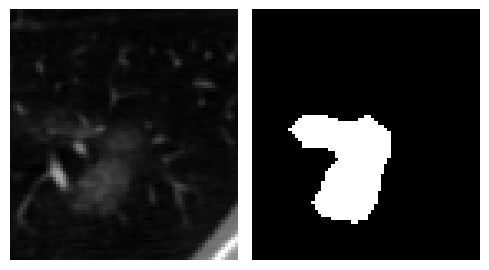

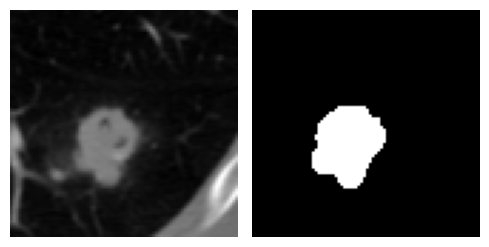

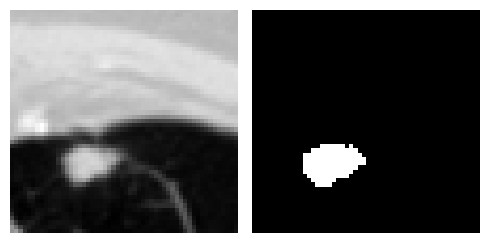

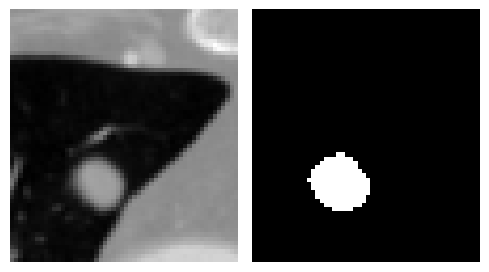

In [59]:
pid= 'LIDC-IDRI-0003'
scan= pl.query(pl.Scan).filter(pl.Scan.patient_id == pid).first()
nods = scan.cluster_annotations()
vol=scan.to_volume()
padding=[(30,10), (10,25), (0,0)]

n=1
print()
for anns in nods:
        #get the concensus for the contours of this nodule
        cmask,cbbox,masks=consensus(anns,clevel=0.5,pad=padding)

        #get the central slice of the computed bounding box
        k=int(0.5*(cbbox[2].stop-cbbox[2].start))

        img=vol[cbbox][:,:,k]

        print(f"Nodule {n}:")
        print(f"shape cmaks{cmask.shape}")
        print(f"Number of annotations: {len(anns)}")

        malignancy=get_malignancy(anns)
        print(f"Malignancy of the nodule: {malignancy}")

        calcification=get_calcification(anns)
        print(f"Patern of calcification of the nodule: {calcification}")

        lobulation=get_lobulation(anns)
        print(f"Degree of lobulation: {lobulation}")

        spiculation=get_spiculation(anns)
        print(f"Extent of spiculation: {spiculation}")

        internal_texture=get_internal_texture(anns)
        print(f"Interanl texture: {internal_texture}")        
              
        diameter,surface_area,volume=get_diameter_surface_area_volume(anns)
        print("Diameter: %.2f mm, Surfuce Area: %.2f mm^2, Volume: %.2f mm^3" % (diameter,
                                         surface_area,
                                         volume))     

        n_pixeis_in_nodule=get_pixeis_in(cmask)
        print(f"Number of pixeis inside the nodule: {n_pixeis_in_nodule}")

        circularity=get_circularity(cmask)
        print(f"Circularity in the slice {k} of the nodule: {circularity}")

        median_hu_in_nodule=get_median_hu(vol[cbbox][cmask])
        print(f"Median of HU inside the nodule: {median_hu_in_nodule}")

        std_hu_in_nodule=get_std_hu(vol[cbbox][cmask])
        print(f"Standard variation of the HU inside the nodule: {std_hu_in_nodule}")

        var_hu_in_nodule=get_var_hu(vol[cbbox][cmask])
        print(f"Variance of HU inside the nodule: {var_hu_in_nodule}")

        mean_hu_in_nodule=get_mean_hu(vol[cbbox][cmask])
        print(f"Median of the HU inside the nodule: {mean_hu_in_nodule}")

        print()
        fig,ax = plt.subplots(1,2,figsize=(5,3))
        ax[0].imshow(vol[cbbox][:,:,k], cmap=plt.cm.gray)
        ax[0].axis('off')

        ax[1].imshow(cmask[:,:,k], cmap=plt.cm.gray)
        ax[1].axis('off')

        plt.tight_layout()
        plt.show
        n+=1

        